In [250]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from scipy.stats import norm, skew

In [251]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [252]:
path = '/content/gdrive/MyDrive/Colab Notebooks'
file_path = os.path.join(path, 'house_prices.xlsx')

In [253]:
df = pd.read_excel(file_path)

In [254]:
df.shape

(414, 7)

In [255]:
df.head()

,Transaction,House age,Distance to MRT station,Number of convenience stores,Latitude,Longitude,House unit price
0,2012.917,32.0,84.87882,10.0,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9.0,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5.0,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5.0,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5.0,24.97937,121.54245,43.1


In [256]:
# Our target column is the price column
print(df['House unit price'].describe())

count    414.000000
mean      37.980193
std       13.606488
min        7.600000
25%       27.700000
50%       38.450000
75%       46.600000
max      117.500000
Name: House unit price, dtype: float64


# Feature Analysis
Useful if we have a lot of features

In [257]:
df['Transaction']=df['Transaction'].astype('category').cat.codes
df['House age']=df['House age'].astype('category').cat.codes
df['Distance to MRT station']=df['Distance to MRT station'].astype('category').cat.codes
df['Number of convenience stores']=df['Number of convenience stores'].astype('category').cat.codes
df['Latitude']=df['Latitude'].astype('category').cat.codes
df['Longitude']=df['Longitude'].astype('category').cat.codes

df.corr()

,Transaction,House age,Distance to MRT station,Number of convenience stores,Latitude,Longitude,House unit price
Transaction,1.000000,0.025994,0.084858,0.009544,0.029510,-0.010722,0.087529
House age,0.025994,1.000000,0.097319,0.031527,0.058345,-0.082108,-0.234873
Distance to MRT station,0.084858,0.097319,1.000000,-0.680977,-0.422565,-0.526721,-0.739636
Number of convenience stores,0.009544,0.031527,-0.680977,1.000000,0.430432,0.434267,0.571005
Latitude,0.029510,0.058345,-0.422565,0.430432,1.000000,0.284794,0.544974
Longitude,-0.010722,-0.082108,-0.526721,0.434267,0.284794,1.000000,0.454807
House unit price,0.087529,-0.234873,-0.739636,0.571005,0.544974,0.454807,1.000000


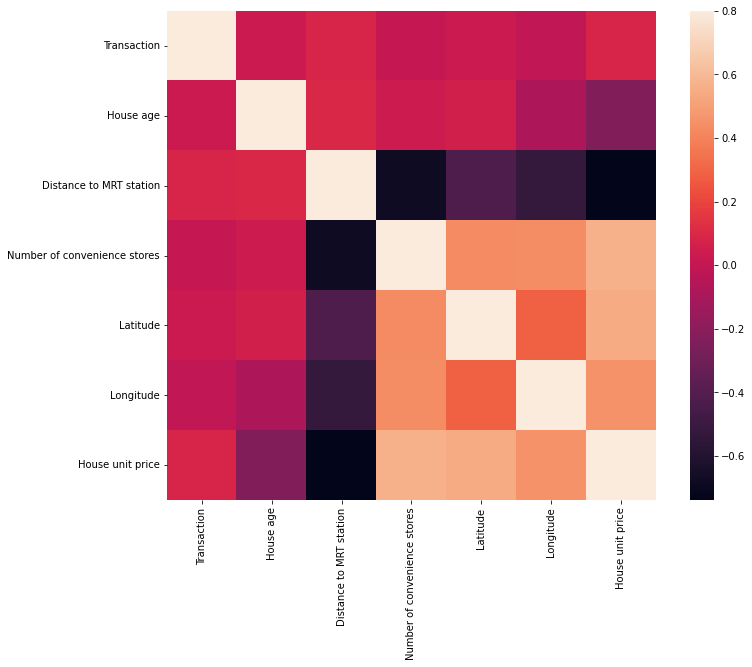

In [258]:
# What are most important features that affect house prices

corrMatrix = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrMatrix, vmax=.8, square=True);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  after removing the cwd from sys.path.


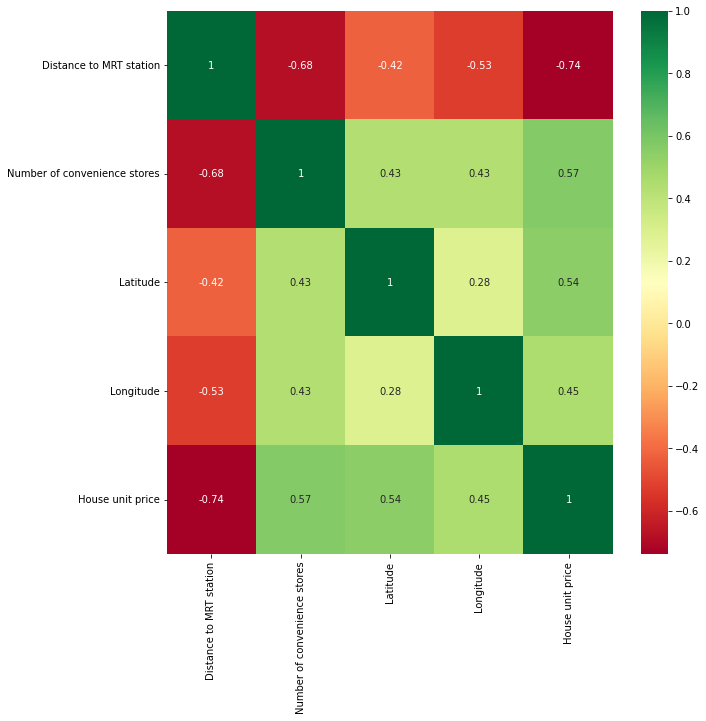

In [259]:
# Keeping only the important features

corr = df.corr()
highest_corr_features = corr.index[abs(corr['House unit price']) > 0.40] | corr.index[abs(corr['House unit price']) < -0.40]
plt.figure(figsize=(10,10))
g = sns.heatmap(df[highest_corr_features].corr(),annot=True,cmap="RdYlGn")

In [260]:
print(highest_corr_features)

Index(['Distance to MRT station', 'Number of convenience stores', 'Latitude',
       'Longitude', 'House unit price'],
      dtype='object')


In [261]:
df = df[highest_corr_features]
id = np.array(range(0,414))
df = df.assign(ID=id)

In [262]:
df.head()

,Distance to MRT station,Number of convenience stores,Latitude,Longitude,House unit price,ID
0,5,10,210,143,37.9,0
1,59,9,188,132,42.2,1
2,134,5,225,188,47.3,2
3,134,5,225,188,54.8,3
4,90,5,183,167,43.1,4


# Looking for missing data

In [263]:
Total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([Total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
Distance to MRT station,0,0.0
Number of convenience stores,0,0.0
Latitude,0,0.0
Longitude,0,0.0
House unit price,0,0.0
ID,0,0.0


No missing data found.

# Feature Engineering

In [264]:
# Fix the skewness in other features
features = df.dtypes[df.dtypes != 'object'].index
skewed_features = df[features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.5]
high_skew

House unit price    0.597677
dtype: float64

In [265]:
for feature in high_skew.index:
    df[feature] = np.log1p(df[feature])

# Separating the data

In [266]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2)

In [267]:
df_train.shape, df_test.shape

((331, 6), (83, 6))

In [268]:
x_train = df_train.drop(['ID', 'House unit price'], axis=1)
y_train = df_train['House unit price']

In [269]:
x_train.shape, y_train.shape

((331, 4), (331,))

In [270]:
x_test = df_test.drop(['ID', 'House unit price'], axis=1)
y_test = df_test['House unit price']
test_id = df_test['ID']

In [271]:
x_test.shape, y_test.shape

((83, 4), (83,))

# Training model

In [272]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [273]:
model = LinearRegression()

In [274]:
model.fit(x_train, y_train)

LinearRegression()

In [275]:
print(model.score(x_test, y_test))

0.6878921315601368


# Prediction

In [276]:
y_pred = np.floor(np.expm1(model.predict(x_test)))
y_pred

array([37., 42., 50., 36., 32., 33., 33., 49., 30., 29., 40., 18., 22.,
       24., 40., 34., 34., 36., 22., 54., 24., 34., 43., 42., 25., 44.,
       46., 43., 34., 45., 36., 48., 43., 38., 19., 43., 27., 42., 29.,
       49., 18., 22., 37., 34., 24., 44., 45., 24., 23., 29., 19., 40.,
       20., 49., 27., 24., 41., 46., 22., 45., 23., 43., 46., 48., 24.,
       52., 23., 29., 33., 44., 19., 23., 37., 25., 38., 49., 26., 44.,
       52., 33., 43., 26., 47.])

In [277]:
y_test = df_test['House unit price']
y_test.head()

246    3.728100
357    3.826465
254    3.966511
311    3.765840
212    3.468856
Name: House unit price, dtype: float64

In [278]:
y_test = np.floor(np.expm1(y_test))
y_test

246    40.0
357    44.0
254    51.0
311    42.0
212    31.0
       ... 
220    78.0
53     38.0
358    45.0
310    24.0
206    43.0
Name: House unit price, Length: 83, dtype: float64

In [280]:
# Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 8.691500


In [279]:
sub = pd.DataFrame()
sub['ID'] = test_id
sub['House unit price'] = y_pred
sub.to_csv(os.path.join(path, 'mysubmission.csv'),index=False)